In [1]:
from lightning_modules import (
    AnyOrderInsertionFlowModule,
)
from sampling import any_order_mask_insertion_euler_sampling, SamplingTraceDatapoint
import torch


torch.set_float32_matmul_precision('high')

In [2]:
!nvidia-smi

Fri Jul 11 16:54:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          On  |   00000000:26:00.0 Off |                  Off |
| N/A   25C    P0             67W /  700W |       0MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
def plot_length_distribution(samples, bin_size=5, figsize=(10, 6), color='blue', show_stats=True):
    """
    Plot the distribution of sequence lengths from generated samples.
    
    Args:
        samples: Tensor of shape [batch_size, max_length] containing the generated samples
        bin_size: Size of bins for the histogram (default: 5)
        figsize: Figure size as tuple (width, height) (default: (10, 6))
        color: Color of the histogram bars (default: 'blue')
        show_stats: Whether to print basic statistics (default: True)
        
    Returns:
        fig, ax: The figure and axis objects for further customization
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get the lengths of samples (number of non-padding tokens)
    lengths = (samples != 3).sum(dim=-1).cpu().numpy()
    
    # Define bins with intervals of bin_size
    min_length = int(np.floor(lengths.min() / bin_size) * bin_size)  # Round down to nearest multiple of bin_size
    max_length = int(np.ceil(lengths.max() / bin_size) * bin_size)   # Round up to nearest multiple of bin_size
    bins = np.arange(min_length, max_length + bin_size, bin_size)    # +bin_size to include the max value
    
    # Count samples in each bin and calculate percentages
    hist, bin_edges = np.histogram(lengths, bins=bins)
    percentages = 100 * hist / len(lengths)  # Convert to percentages
    
    # Create a histogram to visualize the distribution with percentages
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(
        (bin_edges[:-1] + bin_edges[1:]) / 2,  # Center of each bin
        percentages,
        width=np.diff(bin_edges) * 0.9,  # Slightly narrower than bin width for visual clarity
        alpha=0.7,
        color=color,
        edgecolor='black'
    )
    ax.set_xlabel('Sample Length (tokens)')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'Distribution of Sample Lengths ({bin_size}-unit bins)')
    ax.grid(alpha=0.3)
    
    # Add percentage values above each bar
    for i, p in enumerate(percentages):
        if p > 0:  # Only add text for non-zero percentages
            ax.text(
                (bin_edges[i] + bin_edges[i+1]) / 2,  # Center of the bar
                p + 0.5,  # Slightly above the bar
                f'{p:.1f}%',  # Format with 1 decimal place
                ha='center'
            )
    
    plt.tight_layout()
    plt.show()
    
    # Display some basic statistics
    if show_stats:
        print(f"Min length: {lengths.min()}")
        print(f"Max length: {lengths.max()}")
        print(f"Mean length: {lengths.mean():.2f}")
        print(f"Median length: {np.median(lengths):.2f}")
        print(f"Standard deviation: {np.std(lengths):.2f}")
        print(f"Most common length: {np.bincount(lengths).argmax()}")
        print(f"Sum of percentages: {np.sum(percentages):.1f}%")  # Should be 100%
    
    return fig, ax

def plot_length_evolution(trace, sample_id, steps=None, normalize_x=True, model=None, final_length=None, valid=None):
    """
    Plot the evolution of the length (number of non-pad tokens) for a specific sample during sampling.
    
    Args:
        trace: List of tensors with shape [batch_size, max_length] representing the sampling state at each step
        sample_id: Index of the sample to inspect (0 to batch_size-1)
        steps: Number of steps to plot. If None, plot all steps.
        normalize_x: If True, normalize x-axis to range [0, 1] representing sampling progress
        model: The model used for sampling, to access its insertion schedule
        final_length: The final expected length, used to scale the insertion schedule
        valid: List of boolean tensors indicating which samples are valid at each step
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    
    # Validate sample_id
    if sample_id < 0 or sample_id >= trace[0].shape[0]:
        raise ValueError(f"sample_id must be between 0 and {trace[0].shape[0]-1}")
    
    # If steps is not provided, use the length of trace
    if steps is None:
        steps = len(trace)
    else:
        steps = min(steps, len(trace))
    
    # Calculate length at each step for the specified sample
    lengths = []
    for step in range(steps):
        # Count non-pad tokens (tokens that are not 3)
        length = (trace[step][sample_id] != 3).sum().item()
        lengths.append(length)
    
    # Create the plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    if normalize_x:
        # Normalize x-axis from 0 to 1 (representing progress percentage)
        x_values = np.linspace(0, 1, steps)
        ax1.set_xlabel('Normalized Sampling Progress')
    else:
        # Use raw step numbers
        x_values = np.arange(steps)
        ax1.set_xlabel('Step')
    
    # Plot the actual length evolution on the first y-axis
    ax1.plot(x_values, lengths, marker='o', linestyle='-', markersize=4, color='blue', label='Actual Length')
    ax1.set_ylabel('Length (non-pad tokens)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Add annotations for start and end lengths
    ax1.text(x_values[0], lengths[0], f'{lengths[0]}', verticalalignment='bottom', color='blue')
    ax1.text(x_values[-1], lengths[-1], f'{lengths[-1]}', verticalalignment='bottom', color='blue')
    
    # Highlight significant changes
    length_changes = np.diff(lengths)
    significant_steps = [i+1 for i, change in enumerate(length_changes) if abs(change) > 0]
    
    for step in significant_steps:
        x_pos = x_values[step]
        ax1.axvline(x=x_pos, color='r', linestyle='--', alpha=0.2)
    
    # If model is provided, plot the theoretical insertion schedule
    if model is not None and hasattr(model, 'interpolant') and hasattr(model.interpolant, 'insertion_schedule'):
        # Generate time points
        time_points = torch.linspace(0, 1, 100, device=trace[0].device)
        
        # Get the schedule values
        schedule_values = model.interpolant.insertion_schedule.at(time_points).cpu().numpy()
        
        # If final_length is not provided, use the actual final length
        if final_length is None:
            final_length = lengths[-1]
        
        # Scale the schedule values to match the token count
        scaled_schedule = schedule_values * final_length
        
        # Plot the schedule
        ax1.plot(time_points.cpu().numpy(), scaled_schedule, 'r--', label='Theoretical Schedule')
    
    # If valid is provided, plot cumulative invalid count on a second y-axis
    if valid is not None and len(valid) > 0:
        # Create a second y-axis
        ax2 = ax1.twinx()
        ax2.set_ylabel('Cumulative Invalid Count', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        
        # Extract boolean values for the specific sample
        invalid_counts = []
        cumulative_invalid = 0
        
        # Ensure we don't go beyond the length of valid
        valid_steps = min(steps, len(valid))
        
        for step in range(valid_steps):
            # Check if the sample is valid at this step
            if not valid[step][sample_id].item():
                cumulative_invalid += 1
            invalid_counts.append(cumulative_invalid)
        
        # If valid has fewer steps than trace, pad with the last value
        if valid_steps < steps:
            invalid_counts.extend([invalid_counts[-1]] * (steps - valid_steps))
        
        # Plot the cumulative invalid count
        ax2.plot(x_values, invalid_counts, color='green', linestyle='-', marker='.', label='Cumulative Invalid')
        
        # Add a legend for the second y-axis
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    else:
        ax1.legend(loc='upper left')
    
    plt.title(f'Evolution of Length for Sample {sample_id}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Initial length: {lengths[0]}")
    print(f"Final length: {lengths[-1]}")
    print(f"Number of length changes: {len(significant_steps)}")
    if valid is not None:
        print(f"Final cumulative invalid count: {invalid_counts[-1] if invalid_counts else 0}")
    
    # Return the lengths for further analysis if needed
    return lengths

In [4]:
checkpoint_path = "/n/netscratch/albergo_lab/Lab/brianlck/interpretable-flow/checkpoints/bracket/any_order/20250711-151647/last.ckpt"

model = AnyOrderInsertionFlowModule.load_from_checkpoint(checkpoint_path)
# model.swap_to_ema()
model.eval()

AnyOrderInsertionFlowModule(
  (model): OptimizedModule(
    (_orig_mod): AnyOrderMaskInsertionFlow(
      (vocab_embed): EmbeddingLayer()
      (sigma_map): TimestepEmbedder(
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=64, bias=True)
          (1): SiLU()
          (2): Linear(in_features=64, out_features=64, bias=True)
        )
      )
      (rotary_emb): Rotary()
      (blocks): ModuleList(
        (0-2): 3 x DDiTBlock(
          (norm1): LayerNorm()
          (attn_qkv): Linear(in_features=256, out_features=768, bias=False)
          (attn_out): Linear(in_features=256, out_features=256, bias=False)
          (dropout1): Dropout(p=0.0, inplace=False)
          (norm2): LayerNorm()
          (mlp): Sequential(
            (0): Linear(in_features=256, out_features=1024, bias=True)
            (1): GELU(approximate='tanh')
            (2): Linear(in_features=1024, out_features=256, bias=True)
          )
          (dropout2): Dropout(p=0.0, inplace=F

In [5]:
lengths = {4: 0.1, 16: 0.4, 32: 0.4, 64: 0.1}

def binomial_mass(k, n, p):
    """
    Calculate the probability mass function (PMF) for a binomial distribution.
    
    Args:
        k (int): Number of successes
        n (int): Number of trials
        p (float): Probability of success in a single trial
        
    Returns:
        float: Probability mass P(X = k)
    """
    import math
    
    # Calculate binomial coefficient (n choose k)
    try:
        binom_coef = math.factorial(n) / (math.factorial(k) * math.factorial(n - k))
    except ValueError:
        # Handle cases where k > n or negative values
        return 0.0
        
    # Calculate probability mass
    return binom_coef * (p ** k) * ((1 - p) ** (n - k))


def calculate_rate(alpha_t, len_t):
    nom, denom = 0, 0

    for length, probability in lengths.items():
        if length >= len_t:
            print("hi", length, len_t)
            nom += (length - len_t) * probability * binomial_mass(len_t, length, alpha_t)
            denom += probability * binomial_mass(len_t, length, alpha_t)
    
    print(nom, denom)
    return nom / ((len_t + 1) * denom)


calculate_rate(0.9, 20)

hi 32 20
hi 64 20
0.00013176546296497739 1.0980455247081448e-05


0.5714285714285714

In [5]:
def construct_tensor(length, max_length):
    return torch.tensor(
        [0] * (length) + [3] * (max_length - length),
        dtype=torch.int64,
        device=model.device
    ).unsqueeze(0)  # Add batch dimension


len_t = 20
t = 0.9

xt = construct_tensor(len_t, 64)
t = torch.tensor([t], device=model.device)
alpha_t = model.interpolant.insertion_schedule.at(t).item()

print(xt.tolist(), t.item(), alpha_t)

print(model(xt, t).expected_gaps, calculate_rate(alpha_t, len_t))

NameError: name 'model' is not defined

In [7]:
# First, fix the calculate_rate function to remove debugging print statements
def calculate_rate(alpha_t, len_t):
    nom, denom = 0, 0

    for length, probability in lengths.items():
        if length >= len_t:
            nom += (length - len_t) * probability * binomial_mass(len_t, length, alpha_t)
            denom += probability * binomial_mass(len_t, length, alpha_t)
    
    # Ensure denom is not zero to prevent division by zero
    if denom == 0:
        return 0.0
    
    return nom / (denom)  # Prevent division by zero


Final step, removing mask token from sampling
tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')


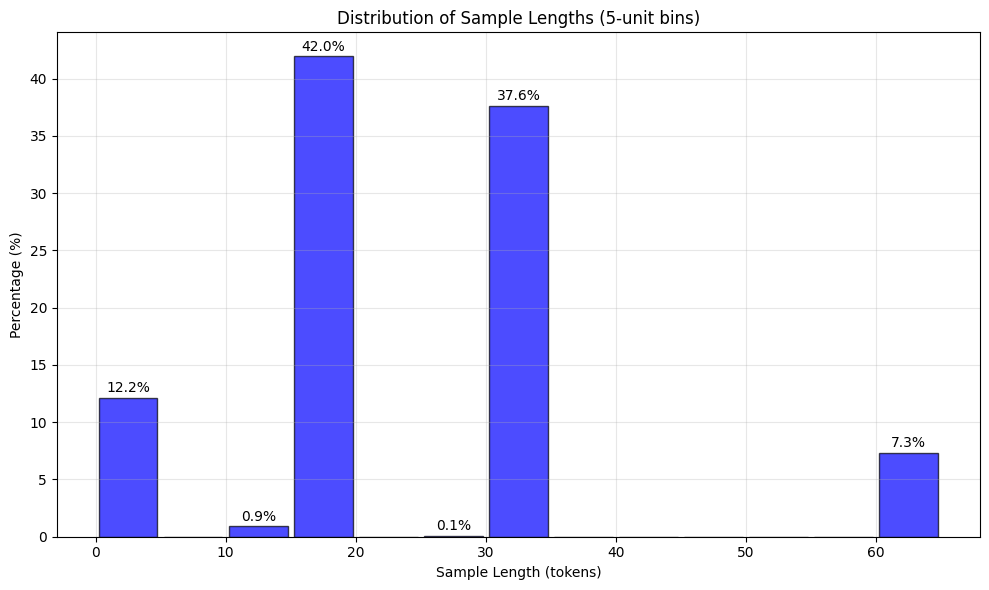

Min length: 3
Max length: 64
Mean length: 23.83
Median length: 16.00
Standard deviation: 14.60
Most common length: 16
Sum of percentages: 100.0%


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Distribution of Sample Lengths (5-unit bins)'}, xlabel='Sample Length (tokens)', ylabel='Percentage (%)'>)

In [5]:
from sampling import any_order_mask_insertion_tau_leaping_sampling

steps = 20000
batch_size = 2000

samples, trace = any_order_mask_insertion_euler_sampling(
    model,
    steps=steps,
    mask=0,
    pad=3,
    batch_size=batch_size,
    max_length=64,
    return_trace=False,
)


plot_length_distribution(samples, bin_size=5, figsize=(10, 6), color='blue', show_stats=True)

In [ ]:
lengths = {4: 0.1, 16: 0.4, 32: 0.4, 64: 0.1}

def binomial_mass(k, n, p):
    """
    Calculate the probability mass function (PMF) for a binomial distribution.
    
    Args:
        k (int): Number of successes
        n (int): Number of trials
        p (float): Probability of success in a single trial
        
    Returns:
        float: Probability mass P(X = k)
    """
    import math
    
    # Calculate binomial coefficient (n choose k)
    try:
        binom_coef = math.factorial(n) / (math.factorial(k) * math.factorial(n - k))
    except ValueError:
        # Handle cases where k > n or negative values
        return 0.0
        
    # Calculate probability mass
    return binom_coef * (p ** k) * ((1 - p) ** (n - k))

def calculate_rate_batch(alpha_t, len_t):
    """
    Calculate rate for a batch of alpha_t and len_t values.
    
    Args:
        alpha_t (torch.Tensor): Tensor of shape (batch_size,)
        len_t (torch.Tensor): Tensor of shape (batch_size,)
        
    Returns:
        torch.Tensor: Tensor of shape (batch_size,) containing calculated rates
    """
    batch_size = alpha_t.shape[0]
    device = alpha_t.device
    
    # Initialize tensors for numerator and denominator
    nom = torch.zeros(batch_size, device=device)
    denom = torch.zeros(batch_size, device=device)
    
    for length, probability in lengths.items():
        # Create mask for valid entries where len_t <= length
        valid_mask = (len_t <= length) & (len_t >= 0)
        
        if not valid_mask.any():
            continue
        
        valid_indices = valid_mask.nonzero(as_tuple=True)[0]
        valid_len_t = len_t[valid_indices]
        valid_alpha_t = alpha_t[valid_indices]
        
        # Calculate binomial probabilities efficiently using torch distribution
        binom_dist = torch.distributions.Binomial(total_count=length, probs=valid_alpha_t)
        binom_probs = binom_dist.log_prob(valid_len_t).exp()
        
        # Update numerator and denominator for valid indices
        nom[valid_indices] += (length - valid_len_t) * probability * binom_probs
        denom[valid_indices] += probability * binom_probs
    
    # Handle division by zero in a vectorized way
    result = torch.zeros_like(nom)
    div_mask = denom > 0
    result[div_mask] = nom[div_mask] / (denom[div_mask])
    
    return result

# Keep the original function for backward compatibility
def calculate_rate(alpha_t, len_t):
    """Legacy scalar version of calculate_rate"""
    if isinstance(alpha_t, torch.Tensor) and alpha_t.ndim > 0:
        return calculate_rate_batch(alpha_t, len_t)
    
    nom, denom = 0, 0
    for length, probability in lengths.items():
        if length >= len_t:
            nom += (length - len_t) * probability * binomial_mass(len_t, length, alpha_t)
            denom += probability * binomial_mass(len_t, length, alpha_t)
    
    if denom == 0:
        return 0.0
    
    return nom /  denom

insertion_schedule = model.interpolant.insertion_schedule

def sample(batch_size):
    steps = 10000
    dt = 1.0 / steps
    t = torch.full((batch_size,), 0.0, device=model.device)
    x = torch.full((batch_size,), 0, device=model.device)  # Initialize with padding token (3)

    for i in range(steps):
        rate = calculate_rate(insertion_schedule.at(t), x)
        rate = rate * insertion_schedule.rate_scale_factor(t)
        inc = torch.poisson(rate * dt).long()
        x = x + inc

        t = t + dt

    return x

sample(100)


tensor([ 8.,  4.,  9.,  4.,  4.,  4., 10.,  3., 10.,  4., 11.,  3.,  4.,  4.,
         4.,  4.,  2.,  4.,  3.,  4., 10.,  4.,  3., 10.,  4.,  9.,  4.,  3.,
         4.,  4.,  4.,  3.,  4.,  4.,  4.,  4.,  3.,  4.,  4.,  4.,  3., 12.,
         9.,  4.,  4.,  4.,  8.,  4.,  3.,  4.,  2.,  8.,  3.,  4.,  4.,  3.,
         3.,  9.,  3.,  9.,  3.,  3.,  8.,  3.,  3., 10.,  4., 10.,  4.,  4.,
         4.,  3.,  2.,  3.,  9.,  4.,  4.,  4.,  7., 10.,  3.,  3.,  9.,  4.,
         3.,  9., 11.,  4.,  4.,  4.,  4.,  3.,  3., 12.,  4.,  4.,  4.,  3.,
         8.,  3.], device='cuda:0')

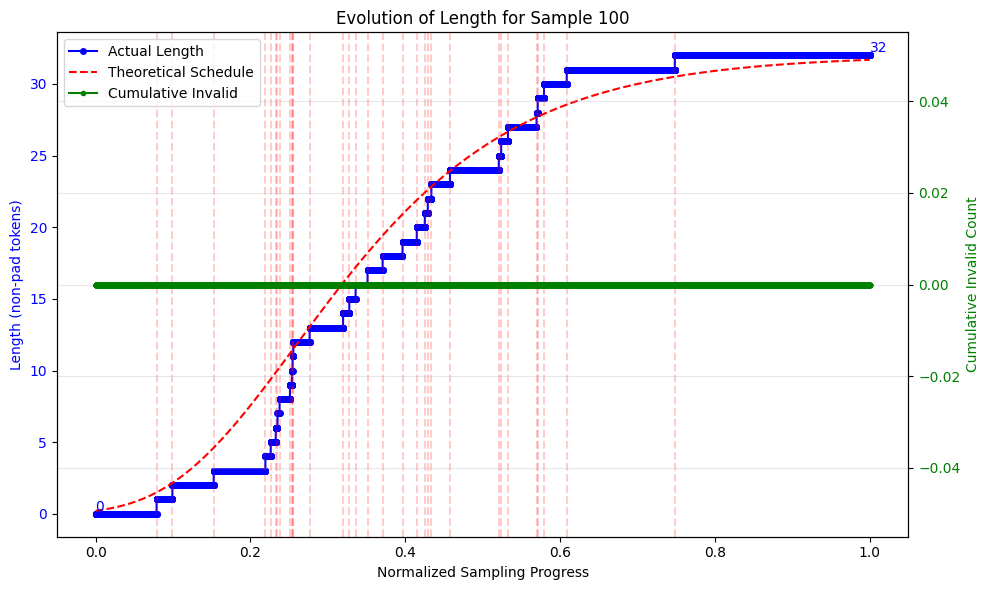

Initial length: 0
Final length: 32
Number of length changes: 32
Final cumulative invalid count: 0


In [11]:
sample_id = 100
lengths = plot_length_evolution(trace, sample_id, normalize_x=True, model=model, final_length=None, valid=valid)

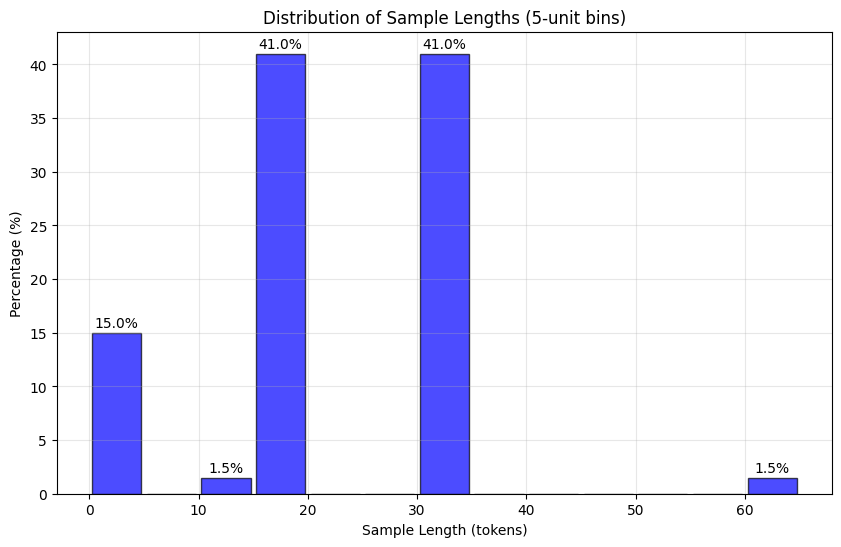

Min length: 3
Max length: 64
Mean length: 21.45
Median length: 16.00
Sum of percentages: 100.0%


In [49]:
from data import get

ImportError: cannot import name 'get' from 'data' (/n/netscratch/albergo_lab/Lab/brianlck/interpretable-flow/data/__init__.py)

In [14]:
def process_trace(trace: list[SamplingTraceDatapoint]):
    event_type_mapping = dict(change="c", insertion="i")
    token_mapping = {0: "m", 1: "(", 2: ")"}

    def _process_datapoint(datapoint: SamplingTraceDatapoint):
        return dict(
            t=datapoint.t,
            a=event_type_mapping[datapoint.event_type],
            tk=token_mapping[datapoint.token],
            i=datapoint.position,
        )

    return [_process_datapoint(datapoint) for datapoint in trace]

In [34]:
from IPython.display import display, HTML
import json

# Select the index of the tensor to visualize
id = 19
assert 0 <= id < batch_size, "id must be in [0, batch_size)"

events = process_trace(trace[id])
print(events)

display(
    HTML(f"""
<style>
.token {{
    display: inline-block;
    padding: 5px 10px;
    margin: 2px;
    border: 1px solid #aaa;
    border-radius: 4px;
    font-family: monospace;
    transition: background 0.5s;
}}
.hi-i {{ background: lightgreen; }}
.hi-c {{ background: yellow; }}
#s {{ min-height: 30px; margin-bottom: 20px; }}
</style>
<div id="s"></div>
<button id="r">Replay</button>
<script>
var ev = {json.dumps(events)};
var s = [];
var delay = 100; // Delay between steps (ms)

function render(hIdx, action) {{
    var container = document.getElementById("s");
    container.innerHTML = "";
    s.forEach(function(token, idx) {{
        var span = document.createElement("span");
        span.className = "token" + (idx === hIdx ? " hi-" + action : "");
        span.textContent = token;
        container.appendChild(span);
    }});
}}

async function run() {{
    s = [];
    render();
    
    for (const e of ev) {{
        if (e.a === "i") {{
            // Insert token at position e.i
            var pos = (e.i < 0 || e.i > s.length) ? Math.floor(s.length / 2) : e.i;
            s.splice(pos, 0, e.tk);
            render(pos, "i");
        }} else {{
            // Change token at position e.i
            var pos = (e.i === undefined || e.i < 0 || e.i >= s.length) ? Math.floor(s.length / 2) : e.i;
            s[pos] = e.tk;
            render(pos, "c");
        }}
        
        // Small delay to make the animation visible (but still synchronous in execution order)
        await new Promise(resolve => setTimeout(resolve, delay));
    }}
}}

document.getElementById("r").onclick = run;
run(); // Start automatically
</script>
""")
)

KeyError: 3